## Neural Network for Liver Disease Prediction

### BMI 543 Final Project 

### Paul Kalnins

kalninsp@ohsu.edu | June 11, 2024


***

### Import Libraries

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import random

*** 

### Project Overview 

The objectives of this project are as follows: 

**Objective 1**: Build a neural network (multilayer perceptron) in Python
  - Use only base python packages (numpy, pandas, matplotlib)
  - Allow for hyperparameter tuning (see list of hyperparameters below)
  - Compare results to Scikit Learn MLP package 


**Objective 2**: Use the network for classification
  - Data: Indian Liver Patient Dataset
  - 10 features (liver biomarkers)
  - Binary outcomes: liver disease or no liver disease 

#### Desired hyperparameters: 

**Adjustable**: 
- Network architecture: be able to specify number of layers and nodes in each layer
- Learning rate
- Activation functions: be able to specific either sigmoid, tanh, relu for hidden activations
- Training epochs
- Classification threshold: adjustable, based on training class imbalance 
- Training batch size

**Consider**: 
- Class imbalance in the data
- Adding L1 regularization 
- Early stopping with validation set

**Evaluation Metrics**:  
- Accuracy
- Precision, recall, f1-score
- Confusion matrix 
- Plot training and validation costs per epoch 



***

### Data

#### Indian Liver Patient Dataset

Ramana,Bendi and Venkateswarlu,N.. (2012). ILPD (Indian Liver Patient Dataset). UCI Machine Learning Repository. https://doi.org/10.24432/C5D02C.


#### Exploratory Data Analysis

The most important aspect I want to investigate here is whether or not there is a class imbalance in the dataset.  This could lead to problems with training using the neural network below.  

In [7]:
# Import & examine data
col_names = ['Age', 'Gender', 'Tot_Bilirubin', 'Dir_Bilirubin', 'Alk_Phos', 
                'ALT', 'AST', 'Tot_Proteins','Albumin', 'AGR', 'Liver_Disease']

df = pd.read_csv("ILData.csv", header=None, names=col_names)
df.head()

,Age,Gender,Tot_Bilirubin,Dir_Bilirubin,Alk_Phos,ALT,AST,Tot_Proteins,Albumin,AGR,Liver_Disease
0,65,Female,0.7,0.1,187,16,18,6.8,3.3,0.90,1
1,62,Male,10.9,5.5,699,64,100,7.5,3.2,0.74,1
2,62,Male,7.3,4.1,490,60,68,7.0,3.3,0.89,1
3,58,Male,1.0,0.4,182,14,20,6.8,3.4,1.00,1
4,72,Male,3.9,2.0,195,27,59,7.3,2.4,0.40,1


##### Create Boxplots

Here, I'll explore the distribution of each feature.  

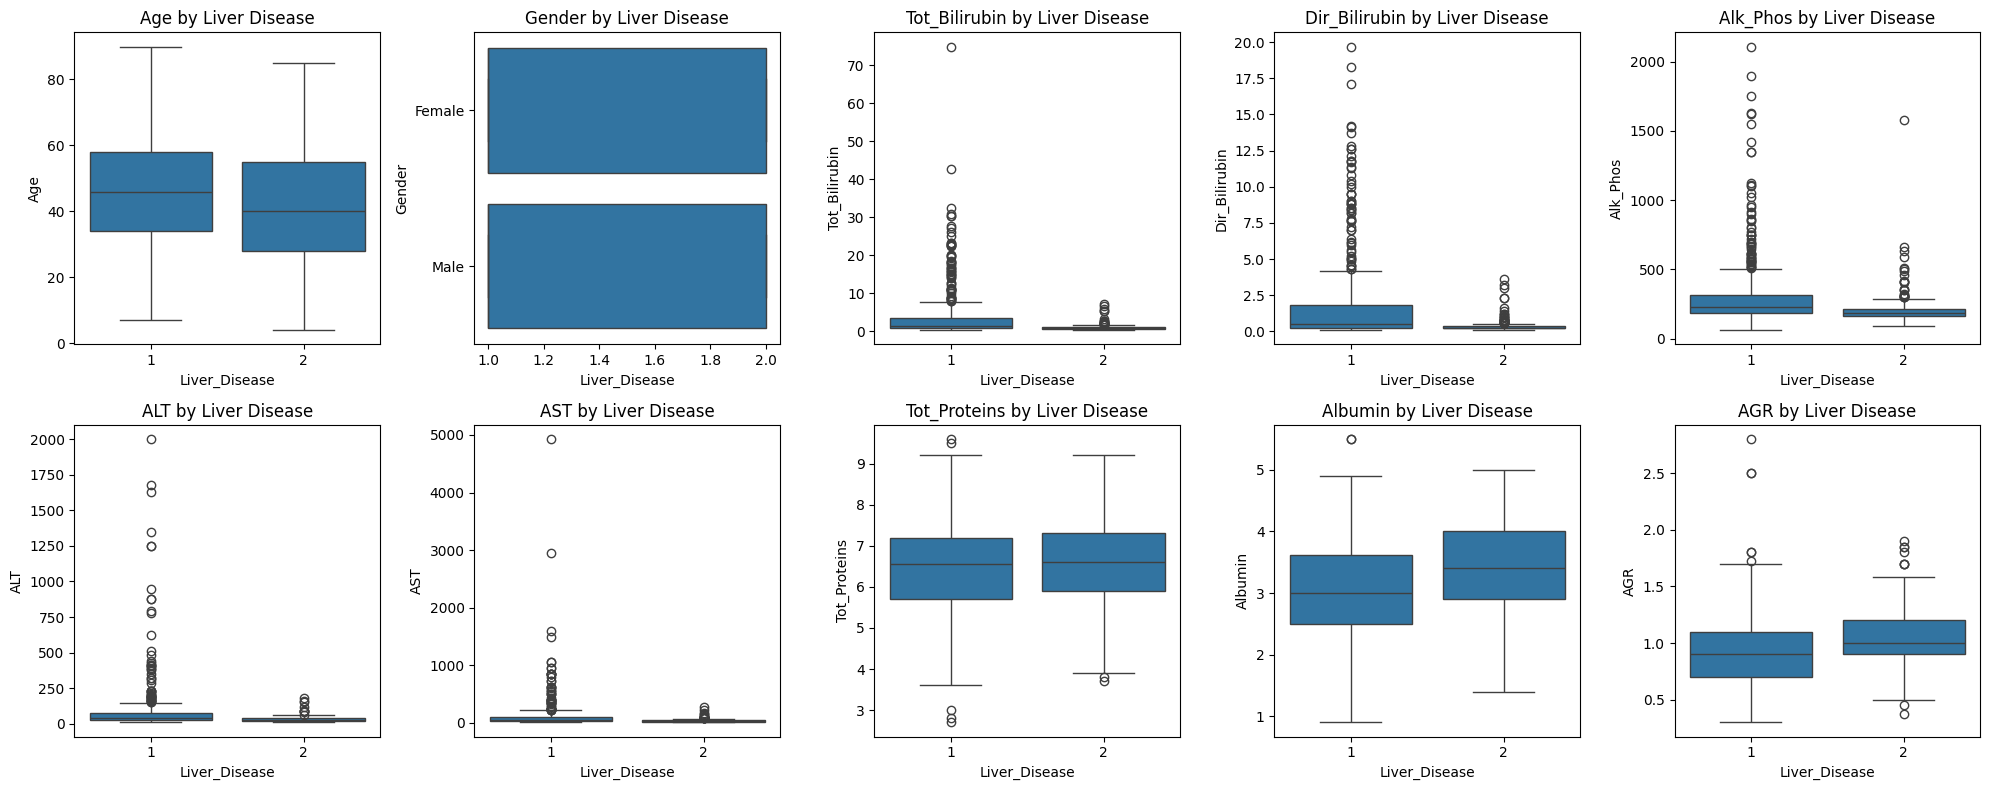

In [8]:
# Number of features
features = df.columns[:-1]
num_features = len(features)

# Create a grid of plots
fig, axes = plt.subplots(nrows=2, ncols=5, figsize=(20, 8))  # Adjust the number of rows and columns accordingly

# Plot each feature in a grid
for i, feature in enumerate(features):
    row, col = divmod(i, 5)
    sns.boxplot(x='Liver_Disease', y=feature, data=df, ax=axes[row, col])
    axes[row, col].set_title(f'{feature} by Liver Disease')

# Adjust layout to prevent overlap
plt.tight_layout()
plt.show()

As can be seen, the distributions for total_bilirubin, direct_bilirubin, alkaline_phosphatase, ALT, and AST are hightly right skewed, especially in the 'no liver disease' class.  While this shouldn't dramatically affect the neural network model, it's something to consider.  

##### Determine Class Counts

In [356]:
class_counts = df['Liver_Disease'].value_counts()
print(class_counts)

gender_counts = df['Gender'].value_counts()
print(gender_counts)


Liver_Disease
1    416
2    167
Name: count, dtype: int64
Gender
Male      441
Female    142
Name: count, dtype: int64


***

### Data Summary: Indian Liver Patient Dataset 

Data represents medical patients in Inida.  

- 583 total patients 
- 441 males, 142 females
- No missing values (but some non-integer values, etc.)
- Note there is a class imbalance: see below


There are 10 features, which are all integer or float values, except for 'Gender': 

- Age (integer; any patient whose age exceeded 89 is listed as being of age '90')
- Gender: Male or Female (string)
- Total Bilirubin (float)
- Direct Bilirubin (float)
- Alkaline Phosphatase (integer)
- Alanine aminotransferase (ALT) (also known as SGPT) (integer)
- Aspartate aminotransferase (AST) (also known as SGOT) (integer)
- Total protein (float)
- Albumin (float)
- Albumin-Globulin ratio (AGR) (float)

The target is 'Liver Disease' (unclear which type or how that was determined), which is set as integers; in the code below, I will convert 2 to 0 for it to work with the machine learning model: 

- Presence of liver disease: 1 (keep as 1)
- Absence of liver disease: 2 (convert to 0)

There are 416 patients with liver disease and 167 patients without liver disease. This is a significant class imbalance and will need to be addessed in the model. 


***

### Neural Network Model Overview 

My neural network contains the following functions and classes: 

Function: `load_and_preprocess_data()`: 
  - Loads data from csv file
  - Splits into X (features matrix) and y (target vector)
  - Converts y == 2 values (no liver disease) to 0; keeps y == 1 values (liver disease) as 1
  - Scales X data: either in range [0,1] or [-1,1] as specified 

Function: `train_test_val_split(X, y)`: 
  - Split data into train, validate, and test sets
  - Allow for adjustments in size of each set
  - For this project, I choose 20% of the data for test data, 10% for validation

Class: `NeuralNetwork`(the actual neural network): 
  - Parameters: 
    - layer_sizes (e.g. [10, 5, 3, 1] is 10 input nodes, 1 output node, 2 hidden layers)
    - Activation: choose between sigmoid, relu, tanh for hidden layers
    - Learning_rate
    - L1_penalty: for L1 regularization

  - Methods: 
    - Initialize weights/biases
    - Forward propagation
    - Cost with L1 penalty
    - Backpropagation
    - Update weights/biases
    - Making predictions based on weights

  - To instantiate an object: model = NeuralNetwork(*params*)

Class `ModelRunner`(runs the neural network model):  
  - Parameters: 
    - Epoch
    - Batch_size
    - Add_weights
    - Early_stopping
    - Patience

  - Methods: 
    - Train model 
    - Evaluate
    - Calculate metrics 
    - Print metrics
    - Plot confusion matrix
    - Run model 

  - To instantiate an object: runner = ModelRunner(model, *params*)
  - Run model: runner.run(data)

**Output**
- Prints metadata
- Accuracy, precision, recall, f1-score
- Plot training and validation costs over epochs
- Create a confusion matrix 

Further details are provided with each function below.  

***

#### Data Preprocessing

The function `load_and_preprocess_data()` loads the csv file with the data, and prepares it in several ways for the neural network model, including the following: 

- In the 'Gender' column, replace 'Female' with 0 and 'Male' with 1 (as integers). 

- There is an issue with a few NaN values in the Albumin-Globulin Ration (AGR) column; I will replace these with mean values of the other entries in the column. 

- Separation of data in an X (feature) matrix and y (target) vector; y target values of 1 kept a 1 and values of 2 are replaced with 0. 

- The data is scaled depending on the value of the `scale_range` hyperparameter; it can be scaled either in the range [0,1] or [-1,1] depending on the need. Since I'll be using tanh activation in the output of the neural network, I'll set the default to [-1,1]. 


In [11]:
def load_and_preprocess_data(file_path, scale=True, scale_range=(-1, 1)):
    # Load dataset
    col_names = ['Age', 'Gender', 'Tot_Bilirubin', 'Dir_Bilirubin', 'Alk_Phos', 
                 'ALT', 'AST', 'Tot_Proteins','Albumin', 'AGR', 'Target']
    df = pd.read_csv(file_path, header=None, names=col_names)

    # Replace 'Female' with 0 and 'Male' with 1
    df['Gender'] = df['Gender'].map({'Female': 0, 'Male': 1})
    
    # Convert all non-numeric values to NaN & fill NaN with mean of the column
    df = df.apply(pd.to_numeric, errors='coerce')
    df.fillna(df.mean(), inplace=True)

    # Separate into features (X) and target (y)
    # Convert y == 1 to 0 and y == 2 to 1 for training model 
    # Convert to np array
    X = df.drop('Target', axis=1).values  
    y = df['Target'].apply(lambda x: 1 if x == 1 else 0).values 
    
    # Custom scaling function (scale either to [0,1] or [-1,1])
    def custom_scale(X, scale_range):
        min_vals = np.min(X, axis=0)
        max_vals = np.max(X, axis=0)
        range_vals = max_vals - min_vals
        
        if scale_range == (0, 1):
            X_scaled = (X - min_vals) / range_vals
        elif scale_range == (-1, 1):
            X_scaled = 2 * (X - min_vals) / range_vals - 1
        else:
            raise ValueError("scale_range must be either (0, 1) or (-1, 1)")
        
        return X_scaled

    if scale: 
        # Normalize the features
        X = custom_scale(X, scale_range)
    
    return X, y


The returned X (feature matrix) and y (target vector) are then input into the `train_test_val_split()` function, which returns training, validation, and test datasets.  For this dataset, I'll set the test size to 20% of the dataset and validation to 10%. Note a random seed is included so that the random permutation is reproducible.  

In [20]:
def train_test_val_split(X, y, test_size=0.2, val_size=0.1, random_state=None):
    
    # Set seed for reproducibility
    np.random.seed(random_state)
    
    # Shuffle indices
    indices = np.random.permutation(len(X))
    
    # Determine size of test set
    test_end = int(len(X) * test_size)
    
    # Split into test set and remaining data
    test_idx = indices[:test_end]
    remaining_idx = indices[test_end:]
    
    # Determine size of validation set from the remaining data
    val_end = int(len(remaining_idx) * val_size)
    
    # Split into validation and training sets
    val_idx = remaining_idx[:val_end]
    train_idx = remaining_idx[val_end:]
    
    # Extract the sets
    X_train, X_val, X_test = X[train_idx], X[val_idx], X[test_idx]
    y_train, y_val, y_test = y[train_idx], y[val_idx], y[test_idx]
    
    return X_train, X_val, X_test, y_train, y_val, y_test

These functions will be used below. 

***

### Neural Network

Below is the neural network, which I created as a class, which is highly tunable with different parameters. The hyperparameters of the network include the following: 

- **layer_sizes**: this is the architecture of the network, as a list of values.  So, [10, 7, 5, 1] would be a network with 10 inputs, 2 hidden layers (of 7 and 5 neurons respectively), and 1 output. 

- **activation**: this specifies the activations of the hidden layers, which can be either 'sigmoid', 'relu', or 'tanh'. For the output layer, a normalized tanh function is used, since that seemed to fit the data the best.   

- **learning_rate**: this sets the learning rate for gradient descent. 

- **l1_penalty**: this sets the rate for the L1 penalty (default will be 0.01)

- **epochs**: this determines the number of training epochs

- **batch_size**: this allows the training batch size to be adjusted.  A `batch_size` = 1 will train the model using **stochastic gradient descent**, whereas a `batch_size` < total length of the training data will train the model using **mini-batch**. 

- **add_weights**: if true, then the cost function will be weighed based on the weights of the classes in the data.

- **early_stopping**: if true, then the model will stop training if the validation cost is no longer improving with training.

- **patience**: this adjusts when early_stopping will occur, allowing the model to train for a 'patience' number of extra epochs beyond the point where the cost function is no longer improving.  


I attempted to create a very modular class.  Some of the primary methods within the class include: 

- `_initialize_parameters()`: this function randomly initializes parameters. After some experimentation, I found that the '**Xavier Initialization**' method of initializing had the best performance. Xavier (or Glorot) Initialization initializes the bias vectors to 0 and the weights to random numbers drawn from a Gaussian distribution, where the mean is 0 and the variance is $\sqrt{(2/(n_i+n_out)}$, where $n_i$ is the dimension of the input neurons and $n_out$ is the dimension of output neurons in the layer.  The initialized parameters are stored in a dictionary (parameters). 

 - Methods to define the sigmoid, relu, and tanh activations, and their derivatives.  

 - `_forward_propagation()`: this calculates the forward propagation through the network and the final normalized sigmoid activation value at the output. 

 - `_compute_cost()`: this function computes the cost based on the binary cross entropy loss. Note I include a small epsilon value to avoid log(0), which can explode to negative infinity.  Here, also, L1 regularization is applied to the cost. I also include a parameters to adjust the cost based on the weights of each class, since the dataset is class imbalanced.  

 - `back_propagation()`: this method conducts back propagation to calculate the gradients of the activations, sum (Z), weights, and biases for each layer. L1 gradients are also applied here. The values are stored in a gradient dictionary.  

 - `update_parameters()`: this method updates the parameters for weights and biases based on gradient descent. The values for weights and biases are then updated in the parameter dictionary.  

 - `train()`: will perform training on the model using the training and validation datasets.  It will run a cycle of forward, cost calculation, backward propagation, and update weights for the specified number of epochs.  Note that the training data can be divided into mini-batches if desired, or the entire training data, one sample at a time, can be used to train (stochastic gradient descent). Here, early stopping is also applied.  

 - `predict()`: using the trained weights, will predict the output on the provided data. The activation threshold is adjustable, and in the second class (ModelRunner) below, the best threshold based on the training data is determined.  

In [315]:
class NeuralNetwork:
    
    def __init__(self, layer_sizes, activation='sigmoid', learning_rate=0.01, l1_penalty=0.01):
        self.layer_sizes = layer_sizes
        self.learning_rate = learning_rate
        self.activation = activation
        self.l1_penalty = l1_penalty  # L1 penalty parameter
        self.parameters = {}
        self._initialize_parameters()
        self.activations = {
            'sigmoid': self._sigmoid,
            'relu': self._relu,
            'tanh': self._tanh
        }
        self.activation_derivatives = {
            'sigmoid': self._sigmoid_derivative,
            'relu': self._relu_derivative,
            'tanh': self._tanh_derivative
        }

    def _initialize_parameters(self):
        np.random.seed(123)
        for i in range(1, len(self.layer_sizes)):
            # Xavier initialization
            self.parameters[f"W{i}"] = np.random.randn(self.layer_sizes[i], self.layer_sizes[i - 1]) * np.sqrt(2.0 / (self.layer_sizes[i - 1] + self.layer_sizes[i]))
            self.parameters[f"b{i}"] = np.zeros((self.layer_sizes[i], 1))

    def _sigmoid(self, x):
        return 1.0 / (1.0 + np.exp(-np.clip(x, -250, 250)))

    def _sigmoid_derivative(self, x):
        sigmoid = self._sigmoid(x)
        return sigmoid * (1 - sigmoid)

    def _relu(self, x):
        return np.maximum(0, x)

    def _relu_derivative(self, x):
        return np.where(x <= 0, 0, 1)

    def _tanh(self, x):
        return np.tanh(x)

    def _tanh_derivative(self, x):
        return 1 - np.tanh(x) ** 2

    def _activation_function(self, x):
        return self.activations[self.activation](x)

    def _activation_derivative(self, x):
        return self.activation_derivatives[self.activation](x)

    def _forward_propagation(self, X):
        caches = []
        A = X.T
        L = len(self.parameters) // 2

        for i in range(1, L):
            A_prev = A
            Wi, bi = self.parameters[f"W{i}"], self.parameters[f"b{i}"]
            Zi = np.dot(Wi, A_prev) + bi
            Ai = self._activation_function(Zi)
            caches.append((A_prev, Zi))
            A = Ai

        WL, bL = self.parameters[f"W{L}"], self.parameters[f"b{L}"]
        ZL = np.dot(WL, A) + bL
        AL = 0.5 * (np.tanh(ZL) + 1)  # Normalize tanh output to [0, 1]
        caches.append((A, ZL))

        return AL, caches

    def _compute_cost(self, AL, Y, add_weights=False):
        m = Y.shape[1]
        AL = np.clip(AL, 1e-8, 1-1e-8) # clip AL to avoid log(0) and log(1)
        base_cost = -np.sum(Y * np.log(AL) + (1 - Y) * np.log(1 - AL)) / m
    
        if add_weights:
            # Calculate class weights
            class_weights = np.sum(Y, axis=1, keepdims=True) / m
            # Apply class weights to the cost
            base_cost *= class_weights
        
        # L1 regularization term
        l1_regularization_cost = 0
        L = len(self.parameters) // 2
        for i in range(1, L + 1):
            Wl = self.parameters[f"W{i}"]
            l1_regularization_cost += np.sum(np.abs(Wl))

        l1_regularization_cost *= (self.l1_penalty / (2 * m))

        total_cost = base_cost + l1_regularization_cost

        return np.squeeze(total_cost)

    def _backward_propagation(self, AL, Y, caches):
        grads = {}
        L = len(caches)
        m = AL.shape[1]
        Y = Y.reshape(AL.shape)

        dAL = - (np.divide(Y, AL + 1e-8) - np.divide(1 - Y, 1 - AL + 1e-8))
        current_cache = caches[-1]
        grads[f"dZ{L}"] = dAL * self._sigmoid_derivative(current_cache[1])
        grads[f"dW{L}"] = np.dot(grads[f"dZ{L}"], current_cache[0].T) / m
        grads[f"db{L}"] = np.sum(grads[f"dZ{L}"], axis=1, keepdims=True) / m

        for i in reversed(range(1, L)):
            current_cache = caches[i - 1]
            dA = np.dot(self.parameters[f"W{i + 1}"].T, grads[f"dZ{i + 1}"])
            grads[f"dZ{i}"] = dA * self._activation_derivative(current_cache[1])
            grads[f"dW{i}"] = np.dot(grads[f"dZ{i}"], current_cache[0].T) / m
            grads[f"db{i}"] = np.sum(grads[f"dZ{i}"], axis=1, keepdims=True) / m

        # L1 regularization gradients
        for i in range(1, L + 1):
            Wl = self.parameters[f"W{i}"]
            grads[f"dW{i}"] += (self.l1_penalty / m) * np.sign(Wl)

        return grads

    def _update_parameters(self, grads):
        L = len(self.parameters) // 2
        for i in range(1, L + 1):
            self.parameters[f"W{i}"] -= self.learning_rate * grads[f"dW{i}"]
            self.parameters[f"b{i}"] -= self.learning_rate * grads[f"db{i}"]

    def train(self, X_train, y_train, X_val, y_val, epochs=1000, batch_size=1, add_weights=False, early_stopping=False, patience=10):
        m_train = X_train.shape[0]
        self.costs_train = []
        self.costs_val = []

        y_train = y_train.reshape(1, m_train)
        y_val = y_val.reshape(1, X_val.shape[0])

        best_val_cost = float('inf')
        no_improvement_count = 0

        for epoch in range(epochs):
            permutation = np.random.permutation(m_train)
            X_train_shuffled = X_train[permutation, :]
            y_train_shuffled = y_train[:, permutation]

            for j in range(0, m_train, batch_size):
                X_batch = X_train_shuffled[j:j + batch_size, :]
                y_batch = y_train_shuffled[:, j:j + batch_size]

                AL, caches = self._forward_propagation(X_batch)
                grads = self._backward_propagation(AL, y_batch, caches)
                self._update_parameters(grads)

            AL_train, _ = self._forward_propagation(X_train)
            cost_train = self._compute_cost(AL_train, y_train, add_weights=add_weights)
            self.costs_train.append(cost_train)

            AL_val, _ = self._forward_propagation(X_val)
            cost_val = self._compute_cost(AL_val, y_val, add_weights=add_weights)
            self.costs_val.append(cost_val)

            if early_stopping:
                if cost_val < best_val_cost:
                    best_val_cost = cost_val
                    no_improvement_count = 0
                else:
                    no_improvement_count += 1

                if no_improvement_count > patience:
                    print(f"Early stopping at epoch {epoch} with validation cost {cost_val:.1f}\n")
                    break

    def predict(self, X, threshold=0.5):
        AL, _ = self._forward_propagation(X)
        predictions = (AL > threshold).astype(int).reshape(-1)
        return AL, predictions


#### Train and Run the Network & Calculate Performance

The following class trains an instance of the neural network, calculates performance metrics (accuracy, precision, recall, and f1-score), prints these values, and then plots both the training and validation costs over epochs, as well as a confusion matrix of the final results.  

The hyperparameters are discussed above.  

In [317]:
class ModelRunner:
    
    def __init__(self, model, layer_sizes, epochs=1000, batch_size=1, add_weights=False, early_stopping=True, patience=10):
        self.model = model
        self.layer_sizes = layer_sizes
        self.epochs = epochs
        self.batch_size = batch_size
        self.add_weights = add_weights
        self.early_stopping = early_stopping
        self.patience = patience
        self.threshold = None  

    def train(self, X_train, y_train, X_val, y_val):
        self.model.train(
            X_train, y_train, X_val, y_val, 
            epochs=self.epochs, 
            batch_size=self.batch_size, 
            add_weights=self.add_weights,
            early_stopping=self.early_stopping,
            patience=self.patience
        )
        
        self.threshold = np.mean(y_train == 1) # Find optimal threshold based on training data

    def evaluate(self, X_test, y_test):
        if self.threshold is None:
            raise ValueError("Threshold not set. Please run the 'train' method first.")
        
        _, predictions = self.model.predict(X_test, threshold=self.threshold)
        metrics = self.calculate_metrics(predictions, y_test)
        return metrics, predictions

    def calculate_metrics(self, predictions, y_test):
        TP = np.sum((predictions == 1) & (y_test == 1))
        FP = np.sum((predictions == 1) & (y_test == 0))
        TN = np.sum((predictions == 0) & (y_test == 0))
        FN = np.sum((predictions == 0) & (y_test == 1))

        accuracy = np.mean(predictions == y_test) * 100
        precision = TP / (TP + FP) if (TP + FP) > 0 else 0
        recall = TP / (TP + FN) if (TP + FN) > 0 else 0
        f1_score = (2 * precision * recall) / (precision + recall) if (precision + recall) > 0 else 0

        total_predictions = len(predictions)
        total_targets = len(y_test)
        
        metrics = {
            'accuracy': accuracy,
            'precision': precision,
            'recall': recall,
            'f1_score': f1_score,
            'true_positives': TP,
            'false_positives': FP,
            'true_negatives': TN,
            'false_negatives': FN,
            'total_predictions': total_predictions, 
            'total_targets': total_targets
        }

        return metrics

    def print_summary(self, metrics):
        # Prints model 'metadata'
        print("\033[1m" + f'NeuralNetwork\n' + "\033[0m")
        
        print(f'Architecture: {self.layer_sizes}')
        print('L1 Regularization Used')
        print(f'Hidden Activation: {self.model.activation} | Output Activation: normalized tanh')
        print(f'Batch Size: {self.batch_size}')
        print(f'Class Weights Added: {self.add_weights}\n')
        print(f'Learning Rate: {self.model.learning_rate}')
        print(f'Training Epochs: {self.epochs}')
        print(f'Early Stopping: {self.early_stopping}')
        print(f"Optimal threshold found during training: {self.threshold:.4f}\n")

        print(f"Total Predictions: {metrics['total_predictions']}\n")
        print(f"Accuracy: {metrics['accuracy']:.1f}% | Precision: {metrics['precision']:.1f} | Recall: {metrics['recall']:.1f} | F1_score: {metrics['f1_score']:.1f}\n")
        print(f"True Positives: {metrics['true_positives']}")
        print(f"False Positives: {metrics['false_positives']}")
        print(f"True Negatives: {metrics['true_negatives']}")
        print(f"False Negatives: {metrics['false_negatives']}")

    
    def plot_results(self, metrics, predictions, y_test):
        # Confusion matrix
        confusion_matrix = np.array([[metrics['true_positives'], metrics['false_positives']],
                                     [metrics['false_negatives'], metrics['true_negatives']]])
    
        # Plotting
        fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(9, 4))

        # Cost plot
        ax1.plot(np.squeeze(self.model.costs_train), label='Training cost')
        ax1.plot(np.squeeze(self.model.costs_val), label='Validation cost')
        ax1.set_xlabel('Epochs')
        ax1.set_ylabel('Cost')
        ax1.set_title('Cost over Epochs')
        ax1.legend()

        # Confusion matrix plot
        labels = ['True', 'False']
        cm_display = [
            [metrics['true_positives'], metrics['false_positives']],
            [metrics['false_negatives'], metrics['true_negatives']]
        ]
        label_text = [['TP', 'FP'], ['FN', 'TN']]
        ax2.matshow(confusion_matrix, cmap='summer') 
        ax2.set_title('Confusion Matrix')
        ax2.set_xlabel('True Label')
        ax2.set_ylabel('Predicted Label')
    
        ax2.set_xticks(np.arange(len(labels)))
        ax2.set_yticks(np.arange(len(labels)))
        ax2.set_xticklabels(labels)
        ax2.set_yticklabels(labels)
    
        # Set the ticks and labels for the x-axis to the bottom
        ax2.xaxis.set_ticks_position('bottom')
    
        for i in range(2):
            for j in range(2):
                ax2.text(j, i, f'{label_text[i][j]}: {cm_display[i][j]:,}', ha='center', va='center', color='black')

        plt.tight_layout()
        plt.show()

    def run(self, X_train, y_train, X_val, y_val, X_test, y_test):
        self.train(X_train, y_train, X_val, y_val)
        metrics, predictions = self.evaluate(X_test, y_test)
        self.print_summary(metrics)
        self.plot_results(metrics, predictions, y_test)


Now, an object of the model can be created and run based on values for the various hyperparameters.  The results are printed below.  

***

#### Run Model 

The following steps are included below: 

- Extract data (and normalized to range (-1, 1) since tanh functions are used as activations)
- Train model, and determine metrics from test data

##### Extract Data

A random seed is included for reproducibility 

In [360]:
file_path = 'ILData.csv'
X, y = load_and_preprocess_data(file_path, scale=True, scale_range=(-1, 1))

X_train, X_val, X_test, y_train, y_val, y_test = train_test_val_split(X, y, test_size=0.2, val_size=0.1, random_state=123)

print(f"X_train shape: {X_train.shape}, y_train shape: {y_train.shape}")
print(f"X_test shape: {X_test.shape}, y_test shape: {y_test.shape}")
print(f"X_val shape: {X_val.shape}, y_val shape: {y_val.shape}")

X_train shape: (421, 10), y_train shape: (421,)
X_test shape: (116, 10), y_test shape: (116,)
X_val shape: (46, 10), y_val shape: (46,)


***

### Train & Test Model 

***

##### Experiment 1

- Use a wide and long neural net
- L1 regularization engaged
- Learning rate = 0.0001
- Batch size = 10
- Epochs = 10000, but early stopping engaged
- Activation function: tanh (for hidden layers) | normalized tanh (for output)
- Class weights are taken into consideration


Early stopping at epoch 346 with validation cost 0.5

NeuralNetwork

Architecture: [10, 15, 10, 7, 5, 3, 2, 1]
L1 Regularization Used
Hidden Activation: tanh | Output Activation: normalized tanh
Batch Size: 10
Class Weights Added: False

Learning Rate: 0.0001
Training Epochs: 10000
Early Stopping: True
Optimal threshold found during training: 0.7102

Total Predictions: 116

Accuracy: 70.7% | Precision: 0.8 | Recall: 0.8 | F1_score: 0.8

True Positives: 63
False Positives: 18
True Negatives: 19
False Negatives: 16


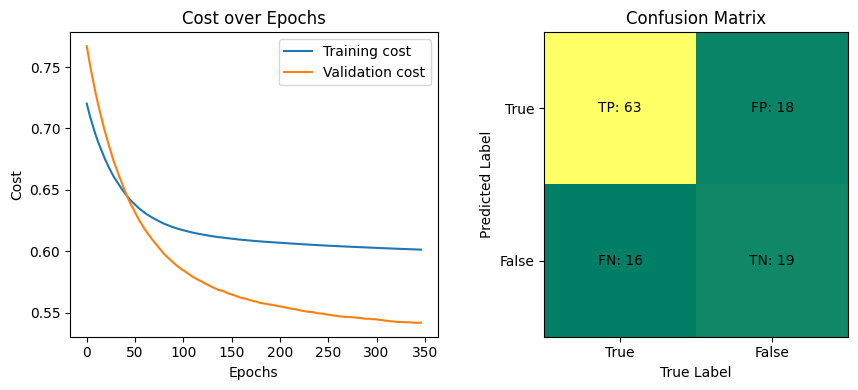

In [340]:
# Experiment 1 Parameters
layer_sizes = [X_train.shape[1], 15, 10, 7, 5, 3, 2, 1]
learning_rate = 0.0001
batch_size = 10
epochs=10000
activation = 'tanh'
add_weights = True
early_stopping = True
patience = 5

model = NeuralNetwork(layer_sizes=layer_sizes, 
                           activation=activation, 
                           learning_rate=learning_rate)

runner = ModelRunner(model, 
                     layer_sizes=layer_sizes, 
                     epochs=epochs, 
                     batch_size=batch_size, 
                     add_weights=add_weights, 
                     early_stopping=early_stopping, 
                     patience=patience, 
                     )

runner.run(X_train, y_train, X_val, y_val, X_test, y_test)



##### Experiment 1 Conclusions

The accuracy reached 70.7% with the wide and long neural network (6 hidden layers). Precision, recall, and f1 score are all 80%, which represents a fairly decent model.  Note the training stopped at just under 350 epochs.  


***

##### Experiment 2

- Use a wide neural net
- L1 regularization engaged
- Learning rate = 0.001
- Batch size = 10
- Epochs = 10000, but early stopping engaged
- Activation function: tanh (for hidden layers) | normalized tanh (for output)
- Class weights are taken into consideration

Early stopping at epoch 139 with validation cost 0.5

NeuralNetwork

Architecture: [10, 20, 15, 1]
L1 Regularization Used
Hidden Activation: tanh | Output Activation: normalized tanh
Batch Size: 10
Class Weights Added: True

Learning Rate: 0.0001
Training Epochs: 10000
Early Stopping: True
Optimal threshold found during training: 0.7102

Total Predictions: 116

Accuracy: 48.3% | Precision: 0.7 | Recall: 0.5 | F1_score: 0.6

True Positives: 38
False Positives: 19
True Negatives: 18
False Negatives: 41


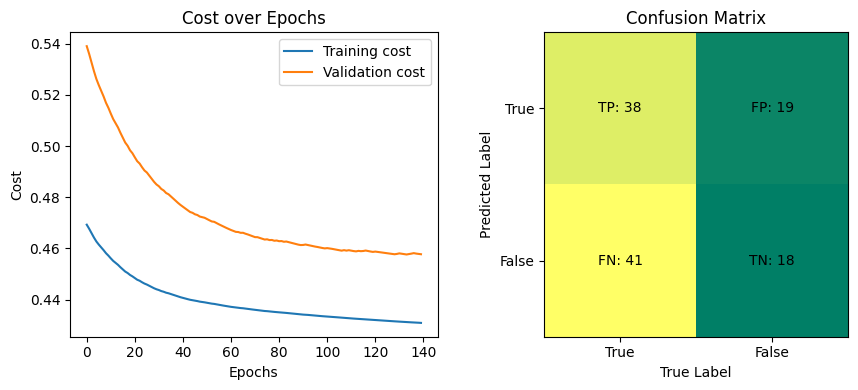

In [343]:
# Experiment 2 Parameters
layer_sizes = [X_train.shape[1], 20, 15, 1]
learning_rate = 0.0001
batch_size = 10
epochs=10000
activation = 'tanh'
add_weights = True
early_stopping = True
patience = 5

model = NeuralNetwork(layer_sizes=layer_sizes, 
                           activation=activation, 
                           learning_rate=learning_rate)

runner = ModelRunner(model, 
                     layer_sizes=layer_sizes, 
                     epochs=epochs, 
                     batch_size=batch_size, 
                     add_weights=add_weights, 
                     early_stopping=early_stopping, 
                     patience=patience, 
                     )

runner.run(X_train, y_train, X_val, y_val, X_test, y_test)


##### Experiment 2 Conclusions

The "wide" and "short" neural network (2 hidden layers) had a fairly poor performance of 48.3% accuracy, 0.7 precision, 0.5 recall, and an f1 score of 0.6.  The model again stopped training under 150 epochs.  

***

##### Experiment 3

- Use a wide and long neural net
- L1 regularization engaged
- Learning rate = 0.01
- Batch size = 1
- Epochs = 10000, but early stopping engaged
- Activation function: tanh (for hidden layers) | normalized tanh (for output)
- Class weights are taken into consideration

Early stopping at epoch 16 with validation cost 0.4

NeuralNetwork

Architecture: [10, 15, 12, 9, 5, 2, 1]
L1 Regularization Used
Hidden Activation: tanh | Output Activation: normalized tanh
Batch Size: 1
Class Weights Added: True

Learning Rate: 0.01
Training Epochs: 10000
Early Stopping: True
Optimal threshold found during training: 0.7102

Total Predictions: 116

Accuracy: 68.1% | Precision: 0.7 | Recall: 1.0 | F1_score: 0.8

True Positives: 79
False Positives: 37
True Negatives: 0
False Negatives: 0


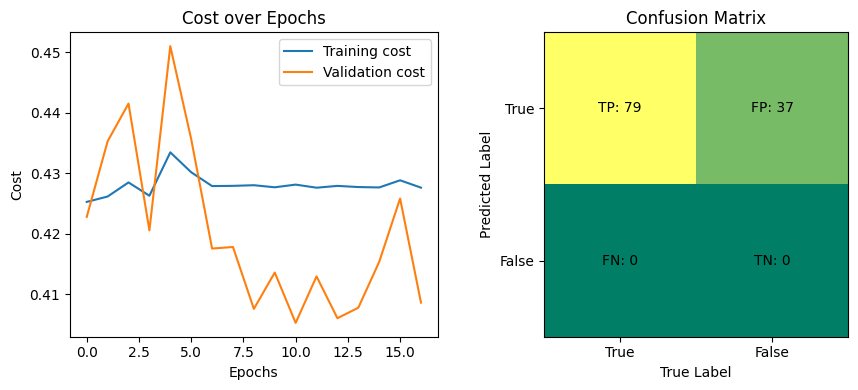

In [357]:
# Experiment 3 Parameters
layer_sizes = [X_train.shape[1], 15, 12, 9, 5, 2, 1]
learning_rate = 0.01
batch_size = 1
epochs=10000
activation = 'tanh'
add_weights = True
early_stopping = True
patience = 5

model = NeuralNetwork(layer_sizes=layer_sizes, 
                           activation=activation, 
                           learning_rate=learning_rate)

runner = ModelRunner(model, 
                     layer_sizes=layer_sizes, 
                     epochs=epochs, 
                     batch_size=batch_size, 
                     add_weights=add_weights, 
                     early_stopping=early_stopping, 
                     patience=patience, 
                     )

runner.run(X_train, y_train, X_val, y_val, X_test, y_test)



##### Experiment 3 Conclusions

Here, stochastic gradient descent is used with a learning rate of 0.01.  Note the large divergences in the validation cost, likely due to the learning rate being too large.  The accuracy was 68.1%, with a recall of 100%.  

***

### Neural Network with Scikit Learn

I will create a class to use the same parameters above and use Scikit learn MLP (Multilayer Perceptron) to classify the data, in order to compare it with my resuts.  

##### Class to Run MLP

In [351]:
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score

class ModelRunnerSKLearn:
    def __init__(self, model, layer_sizes, epochs=1000, batch_size=1, early_stopping=True, patience=10):
        self.model = model
        self.layer_sizes = layer_sizes
        self.epochs = epochs
        self.batch_size = batch_size
        self.early_stopping = early_stopping
        self.patience = patience
        self.threshold = None  # Placeholder for threshold

    def train(self, X_train, y_train, X_val, y_val):
        self.model.fit(X_train, y_train)
        
        # Find the optimal threshold based on training data
        self.threshold = np.mean(y_train == 1)

    def evaluate(self, X_test, y_test):
        if self.threshold is None:
            raise ValueError("Threshold not set. Please run the 'train' method first.")
        
        predictions = self.model.predict(X_test)
        metrics = self.calculate_metrics(predictions, y_test)
        return metrics, predictions

    def calculate_metrics(self, predictions, y_test):
        accuracy = accuracy_score(y_test, predictions) * 100
        precision = precision_score(y_test, predictions)
        recall = recall_score(y_test, predictions)
        f1 = f1_score(y_test, predictions)

        confusion = confusion_matrix(y_test, predictions)
        TN, FP, FN, TP = confusion.ravel()

        total_predictions = len(predictions)
        total_targets = len(y_test)

        metrics = {
            'accuracy': accuracy,
            'precision': precision,
            'recall': recall,
            'f1_score': f1,
            'true_positives': TP,
            'false_positives': FP,
            'true_negatives': TN,
            'false_negatives': FN,
            'total_predictions': total_predictions,
            'total_targets': total_targets
        }

        return metrics

    def print_summary(self, metrics):
        print("\033[1m" + f'NeuralNetwork (Scikit-learn)\n' + "\033[0m")
        
        print(f'Architecture: {self.layer_sizes}')
        print(f'Batch Size: {self.batch_size}')
        print(f'Early Stopping: {self.early_stopping}')
        print(f"Optimal threshold found during training: {self.threshold:.4f}\n")

        print(f"Total Predictions: {metrics['total_predictions']}\n")
        print(f"Accuracy: {metrics['accuracy']:.1f}% | Precision: {metrics['precision']:.1f} | Recall: {metrics['recall']:.1f} | F1_score: {metrics['f1_score']:.1f}\n")
        print(f"True Positives: {metrics['true_positives']}")
        print(f"False Positives: {metrics['false_positives']}")
        print(f"True Negatives: {metrics['true_negatives']}")
        print(f"False Negatives: {metrics['false_negatives']}")

    def plot_confusion_matrix(self, metrics):
        # Confusion matrix
        confusion_matrix = np.array([[metrics['true_positives'], metrics['false_positives']],
                                     [metrics['false_negatives'], metrics['true_negatives']]])
    
        # Plotting
        fig, ax = plt.subplots(figsize=(4, 4))

        ax.matshow(confusion_matrix, cmap='summer')
        ax.set_title('Confusion Matrix')
        ax.set_xlabel('True Label')
        ax.set_ylabel('Predicted Label')
    
        labels = ['True', 'False']
        ax.set_xticks(np.arange(len(labels)))
        ax.set_yticks(np.arange(len(labels)))
        ax.set_xticklabels(labels)
        ax.set_yticklabels(labels)
    
        # Set the ticks and labels for the x-axis to the bottom
        ax.xaxis.set_ticks_position('bottom')
    
        # Text annotation
        label_text = [['TP', 'FP'], ['FN', 'TN']]
        for i in range(2):
            for j in range(2):
                ax.text(j, i, f'{label_text[i][j]}: {confusion_matrix[i, j]:,}', ha='center', va='center', color='black')

        plt.tight_layout()
        plt.show()

    def run(self, X_train, y_train, X_val, y_val, X_test, y_test):
        self.train(X_train, y_train, X_val, y_val)
        metrics, predictions = self.evaluate(X_test, y_test)
        self.print_summary(metrics)
        self.plot_confusion_matrix(metrics)




##### Load Data

Scale to range (0, 1)

In [352]:
file_path = 'ILData.csv'
X, y = load_and_preprocess_data(file_path, scale=True, scale_range=(-1, 1))

***

##### Experiment 1

NeuralNetwork (Scikit-learn)

Architecture: [10, 15, 10, 7, 5, 3, 2, 1]
Batch Size: 10
Early Stopping: True
Optimal threshold found during training: 0.7102

Total Predictions: 116

Accuracy: 68.1% | Precision: 0.7 | Recall: 1.0 | F1_score: 0.8

True Positives: 79
False Positives: 37
True Negatives: 0
False Negatives: 0


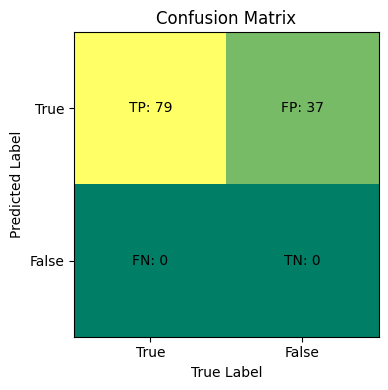

In [358]:
# Experiment 1 Parameters
layer_sizes = [X_train.shape[1], 15, 10, 7, 5, 3, 2, 1]
learning_rate = 0.0001
batch_size = 10
epochs = 10000
early_stopping = True
patience = 5
activation = 'tanh'

# Initialize the MLPClassifier
model_sklearn = MLPClassifier(hidden_layer_sizes=layer_sizes[1:], 
                              activation=activation, 
                              learning_rate_init=learning_rate,
                              batch_size=batch_size,
                              max_iter=epochs,
                              early_stopping=early_stopping,
                              n_iter_no_change=patience,
                              verbose=False)

# Initialize ModelRunnerSKLearn
runner_sklearn = ModelRunnerSKLearn(model_sklearn, 
                                    layer_sizes=layer_sizes, 
                                    epochs=epochs, 
                                    batch_size=batch_size, 
                                    early_stopping=early_stopping, 
                                    patience=patience)

# Run the model
runner_sklearn.run(X_train, y_train, X_val, y_val, X_test, y_test)

##### Conclusions for Scikit Learn MLP Experiment 1

Using the exact same parameters and data I used in experiment 1 for my own model, the Scikit learn MLP package produced similar results, with accuracy of 66.4% (worse than my model at 70.3%), with with slightly better recall than my model (0.9 vs. 0.8).  

***

##### Experiment 2

NeuralNetwork (Scikit-learn)

Architecture: [10, 20, 15, 1]
Batch Size: 10
Early Stopping: True
Optimal threshold found during training: 0.7102

Total Predictions: 116

Accuracy: 64.7% | Precision: 0.7 | Recall: 0.9 | F1_score: 0.8

True Positives: 73
False Positives: 35
True Negatives: 2
False Negatives: 6


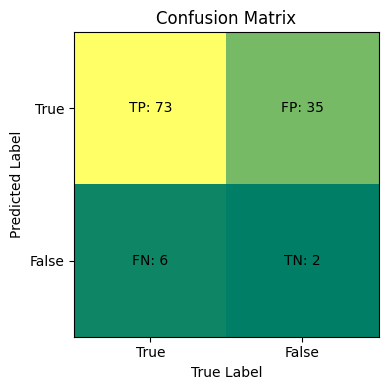

In [354]:
# Experiment 1 Parameters
layer_sizes = [X_train.shape[1], 20, 15, 1]
learning_rate = 0.0001
batch_size = 10
epochs=10000
activation = 'tanh'
early_stopping = True
patience = 5

# Initialize the MLPClassifier
model_sklearn = MLPClassifier(hidden_layer_sizes=layer_sizes[1:], 
                              activation=activation, 
                              learning_rate_init=learning_rate,
                              batch_size=batch_size,
                              max_iter=epochs,
                              early_stopping=early_stopping,
                              n_iter_no_change=patience,
                              verbose=False)

# Initialize ModelRunnerSKLearn
runner_sklearn = ModelRunnerSKLearn(model_sklearn, 
                                    layer_sizes=layer_sizes, 
                                    epochs=epochs, 
                                    batch_size=batch_size, 
                                    early_stopping=early_stopping, 
                                    patience=patience)

# Run the model
runner_sklearn.run(X_train, y_train, X_val, y_val, X_test, y_test)

##### Conclusions for Scikit Learn MLP Experiment 2

Using the same parameters as in experiment 2 using my model, the scikit learn MLP performed somewhat better, with accuracy of 64.7% (vs. my model accuracy of 48.3%), precision of 0.7 (vs. my model precision of 0.70), recall of 0.9 (vs. my model recall of 0.5), and f1 score of 0.8 (vs. my model f1 score of 0.6).  

***

##### Experiment 3


NeuralNetwork (Scikit-learn)

Architecture: [10, 15, 12, 9, 5, 2, 1]
Batch Size: 1
Early Stopping: True
Optimal threshold found during training: 0.7102

Total Predictions: 116

Accuracy: 68.1% | Precision: 0.7 | Recall: 1.0 | F1_score: 0.8

True Positives: 79
False Positives: 37
True Negatives: 0
False Negatives: 0


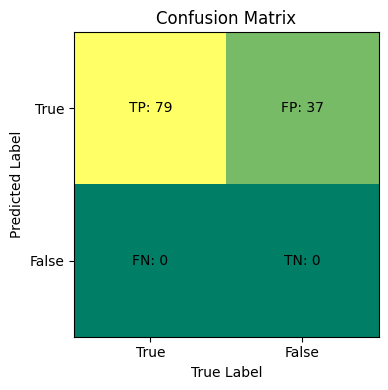

In [359]:
# Experiment 1 Parameters
layer_sizes = [X_train.shape[1], 15, 12, 9, 5, 2, 1]
learning_rate = 0.01
batch_size = 1
epochs=10000
activation = 'tanh'
early_stopping = True
patience = 5


# Initialize the MLPClassifier
model_sklearn = MLPClassifier(hidden_layer_sizes=layer_sizes[1:], 
                              activation=activation, 
                              learning_rate_init=learning_rate,
                              batch_size=batch_size,
                              max_iter=epochs,
                              early_stopping=early_stopping,
                              n_iter_no_change=patience,
                              verbose=False)

# Initialize ModelRunnerSKLearn
runner_sklearn = ModelRunnerSKLearn(model_sklearn, 
                                    layer_sizes=layer_sizes, 
                                    epochs=epochs, 
                                    batch_size=batch_size, 
                                    early_stopping=early_stopping, 
                                    patience=patience)

# Run the model
runner_sklearn.run(X_train, y_train, X_val, y_val, X_test, y_test)

##### Conclusions Scikit learn MLP Experiment 3

Using the same parameters I used for my model in experiment 3, the scikit learn MLP achieved identical results.  

***

### Final Conclusions

**My Neural Network** 
 
- Performance of my network is similar to the Scikit Learn (MLP) results
- Was challenging to figure out backpropagation for all the weights and biases! 
- Tanh as output and hidden layer activations gave best results 
- L1 regularization improved accuracy and training time

**Results on Indian Liver Patient Data**

- Class imbalance in the data: had to account for that by setting the prediction threshold based on classes in the training data
- Models are not highly accurate (generally < 70%)
- Precision and recall acceptable but many false positives! 
- Trained quickly (within a few seconds)

**Future Directions**

- Could probably remove some parameters (such as cost adjustment by class weight)
- Performance is likely limited with this dataset 



***

BMI 543 Final Project | Paul Kalnins (kalninsp@ohsu.edu) | June 2024